# Your info

Full name: M.Amin Ghasvari

Student ID: 97521432

Notice: **You can add new cells for each part.**

# Q1.A. Kohonen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
class Kohonen:
    # distance measurement mechanisms
    COSINE = 'cosine'
    EUCLIDEAN = 'euclidean'
    NONE = 'none'

    LEARNING_RATE_DECAY = 1
    UPDATE_RANGE_FACTOR = 0.25
    UPDATE_RANGE_DECAY = 1

    def __init__(self, width, height, dimension):
        self.x = width
        self.y = height
        self.node_dim = dimension

        # fitting main variables
        self.n_iter = 0  # number of the iterations
        self.batch_size = 0  # number of each batch
        self.input_arr = np.array([])  # input array, given in fit function
        self.dist_method = Kohonen.NONE  # the distance mechanism

        self.node_vectors = np.array([])  # nodes' vectors

        # learning rate
        self.learning_rate = 0

        self.update_range = 0  # the range and distance that would be updated
        self.neighbor_diff = np.array([])

        self.weights = np.array([])  # the neighbor weights
        self.x_delta = []
        self.y_delta = []

    def init_map(self):
        """
        generates random numbers for node vectors and normalize them with mean of the input array.
        :return:
        """
        random_array = np.random.rand(self.y, self.x, self.node_dim)
        normal_factor = (np.mean(self.input_arr) / np.mean(random_array))
        self.node_vectors = random_array * normal_factor

    def distance(self, vector_a, vector_b):
        """
        calculate the distance between vector_a and vector_b
        :param vector_a:
        :param vector_b:
        :return:
        """
        if self.dist_method == Kohonen.COSINE:
            # https://en.wikipedia.org/wiki/Cosine_similarity
            dist = 1. - np.dot(vector_a, vector_b) / (np.linalg.norm(vector_a) * np.linalg.norm(vector_b))
        elif self.dist_method == Kohonen.EUCLIDEAN:
            dist = np.linalg.norm(vector_a - vector_b)
        else:
            raise TypeError
        return dist

    def update_node_vectors(self, closest_nodes_idx):
        """
        updating the weights
        :param closest_nodes_idx:
        :return:
        """
        for idx in range(closest_nodes_idx.shape[0]):
            y = closest_nodes_idx[idx, 0]
            x = closest_nodes_idx[idx, 1]
            inp_idx = closest_nodes_idx[idx, 2]
            input_vector = self.input_arr[inp_idx]

            x_range = x + self.x_delta + self.update_range
            y_range = y + self.y_delta + self.update_range

            previous = self.node_vectors[y_range, x_range]

            update_vector = self.weights * self.learning_rate * (np.expand_dims(input_vector, axis=0) - previous)

            self.node_vectors[y_range, x_range, :] += update_vector

    def find_best_matching_node(self, data_vector):
        """
        this method is for finding best & closest vector.
        :param data_vector:
        :return: (x, y, distance) coordinates and distance
        """
        min_dist = None
        x = None
        y = None
        for y_idx in range(self.y):
            for x_idx in range(self.x):
                node_vector = self.node_vectors[y_idx + self.update_range, x_idx + self.update_range]
                dist = self.distance(data_vector, node_vector)
                if min_dist is None or min_dist > dist:
                    min_dist = dist
                    x = x_idx
                    y = y_idx

        return y, x, min_dist

    def calculate_neighbor_diff(self):
        """
        find diff for calculating sigma. diff is (x[i,j] - mean) ^ 2
        :return:
        """
        size = self.update_range * 2
        mean = size / 2.0

        diff = []
        y_delta = []
        x_delta = []
        for i in range(size):
            diff.append([])
            for j in range(size):
                diff[i].append([])
                for k in range(self.node_dim):
                    diff[i][j].append((j - mean) ** 2.0 + (i - mean) ** 2.0)
                y_delta.append(i - int(mean))
                x_delta.append(j - int(mean))

        self.neighbor_diff = np.array(diff)
        self.x_delta = np.array(x_delta, dtype=np.int32)
        self.y_delta = np.array(y_delta, dtype=np.int32)

    def calculate_neighbor_effect(self, iteration):
        """
        calculate the effect of update for the neighbors using Gaussian bell equation.
        :param iteration: the equation depends on the iteration index
        :return:
        """

        size = self.update_range * 2

        # standard deviation
        standard_deviation_factor = (size / 2) * Kohonen.UPDATE_RANGE_DECAY ** (iteration * 0.3 + 1)
        standard_deviation = standard_deviation_factor * (np.sum(self.neighbor_diff) ** (1 / 2)) / size ** 2

        # standard calculate the Gaussian bell plot
        e_factor = 1.0 / (math.sqrt(2 * math.pi) * standard_deviation)
        e_exponent_factor = (-1 / 2) * (1 / standard_deviation) ** 2
        weights = e_factor * math.e ** (e_exponent_factor * self.neighbor_diff)

        weights /= np.max(weights)
        weights = weights.reshape(size * size, 3)
        self.weights = weights

    def fit(self, input_arr, n_iter, batch_size=30, learning_rate=0.25, random_sampling=1.0, dist_method=EUCLIDEAN):
        """
        fit method is for training kohonen map.
        :param input_arr:
        :param n_iter:
        :param batch_size:
        :param learning_rate:
        :param random_sampling:
        :param dist_method:
        :return:
        """

        self.input_arr = input_arr
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.dist_method = dist_method
        self.learning_rate = learning_rate
        self.update_range = int(min(self.x, self.y) * Kohonen.UPDATE_RANGE_FACTOR)

        self.init_map()

        # add some fake element to the vectors to ease the process of updating neighbors
        radius = self.update_range
        size = 2 * radius
        tmp_node_vectors = np.zeros((self.y + size, self.x + size, self.node_dim))
        tmp_node_vectors[radius: radius + self.y, radius: radius + self.x] = self.node_vectors.copy()
        self.node_vectors = tmp_node_vectors

        # sampling and batches
        n_samples = int(self.input_arr.shape[0] * random_sampling)
        data_idx_arr = np.arange(self.input_arr.shape[0])
        np.random.shuffle(data_idx_arr)
        batch_count = math.floor(n_samples / self.batch_size)

        self.calculate_neighbor_diff()

        # training
        for iter_idx in range(self.n_iter):

            # calculate update effect on the neighbors
            self.calculate_neighbor_effect(iter_idx)

            # Temporary variables
            total_dist = 0

            for batch in range(batch_count):
                closest_nodes_idx = np.zeros((self.batch_size, 3), dtype=np.int32)

                for item in range(self.batch_size):
                    input_idx = data_idx_arr[batch * self.batch_size + item]
                    input_vector = self.input_arr[input_idx]
                    y, x, dist = self.find_best_matching_node(input_vector)
                    closest_nodes_idx[item, 0] = y
                    closest_nodes_idx[item, 1] = x
                    closest_nodes_idx[item, 2] = input_idx
                    total_dist += dist

                self.update_node_vectors(closest_nodes_idx)

            print('Iteration {}/{} Average distance = {}'.format(iter_idx + 1, self.n_iter, total_dist / n_samples))

            self.learning_rate *= Kohonen.LEARNING_RATE_DECAY

        import matplotlib.pyplot as plt
        plt.imshow((self.node_vectors * 100).astype(int))
        plt.show()

        # Remove padding from the vector map
        self.node_vectors = self.node_vectors[self.update_range: self.update_range + self.y,
                            self.update_range: self.update_range + self.x]

        print("Training has been done !")


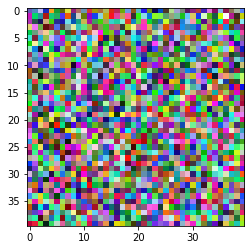

In [3]:
    NUMBER_OF_PIXELS = 1600

    # generating 1600 rgb colors
    pixels = np.random.randint(0, 255, NUMBER_OF_PIXELS * 3) / 100  # scale them into [0, 2.55]
    pixels = pixels.reshape(NUMBER_OF_PIXELS, 3)  # reshape them to rgb shape 1 * 3
    initial_pixels = pixels.reshape((40, 40, 3))
    plt.imshow((initial_pixels * 100).astype(int))
    plt.show()

Iteration 1/20 Average distance = 0.38334824777644155
Iteration 2/20 Average distance = 0.3709910630604407
Iteration 3/20 Average distance = 0.37214070725175397
Iteration 4/20 Average distance = 0.36499568572276364
Iteration 5/20 Average distance = 0.36388078804882884
Iteration 6/20 Average distance = 0.3608497199939
Iteration 7/20 Average distance = 0.3610701033587841
Iteration 8/20 Average distance = 0.3630742375329059
Iteration 9/20 Average distance = 0.36229316117653754
Iteration 10/20 Average distance = 0.3577243148473997
Iteration 11/20 Average distance = 0.3606179562297101
Iteration 12/20 Average distance = 0.36017718393166664
Iteration 13/20 Average distance = 0.3626820780312396
Iteration 14/20 Average distance = 0.3573605107038034
Iteration 15/20 Average distance = 0.3586435800315451
Iteration 16/20 Average distance = 0.3637424151413178
Iteration 17/20 Average distance = 0.36657324624640086
Iteration 18/20 Average distance = 0.3738830025658697
Iteration 19/20 Average distance 

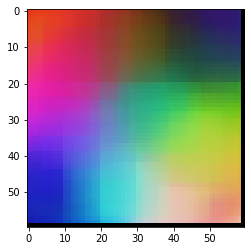

Training has been done !


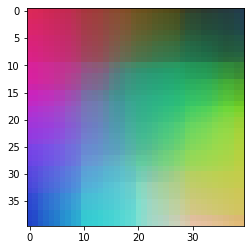

In [4]:
    # set initial variables
    som = Kohonen(dimension=3, width=40, height=40)

    # fitting to the Kohonen map
    som.fit(pixels, random_sampling=0.4, n_iter=20, dist_method=Kohonen.EUCLIDEAN)

    result = (som.node_vectors * 100).astype(int)
    plt.imshow(result)
    plt.show()

Iteration 1/20 Average distance = 0.007238321139882542
Iteration 2/20 Average distance = 0.004742612030519847
Iteration 3/20 Average distance = 0.004332082767549854
Iteration 4/20 Average distance = 0.0042964906458975
Iteration 5/20 Average distance = 0.0044240614041779645
Iteration 6/20 Average distance = 0.004470276391047875
Iteration 7/20 Average distance = 0.004441946735189814
Iteration 8/20 Average distance = 0.004432417283674365
Iteration 9/20 Average distance = 0.0043233787818662455
Iteration 10/20 Average distance = 0.004371164270182239
Iteration 11/20 Average distance = 0.004132998478457036
Iteration 12/20 Average distance = 0.0043610098972258204
Iteration 13/20 Average distance = 0.004717237178199174
Iteration 14/20 Average distance = 0.004438560087007336
Iteration 15/20 Average distance = 0.004027040664375189
Iteration 16/20 Average distance = 0.004077027366648824
Iteration 17/20 Average distance = 0.004055858053411967
Iteration 18/20 Average distance = 0.004113153023937376


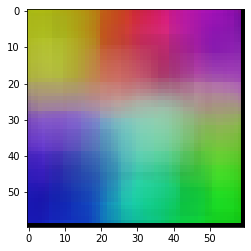

Training has been done !


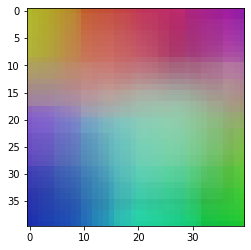

In [5]:
    # set initial variables
    som = Kohonen(dimension=3, width=40, height=40)

    # fitting to the Kohonen map
    som.fit(pixels, random_sampling=0.4, n_iter=20, dist_method=Kohonen.COSINE)

    result = (som.node_vectors * 100).astype(int)
    plt.imshow(result)
    plt.show()

# Q1.B. Kohonen

In [6]:
class Kohonen:
    # distance measurement mechanisms
    COSINE = 'cosine'
    EUCLIDEAN = 'euclidean'
    NONE = 'none'

    LEARNING_RATE_DECAY = 0.76
    UPDATE_RANGE_FACTOR = 0.25
    UPDATE_RANGE_DECAY = 1

    def __init__(self, width, height, dimension):
        self.x = width
        self.y = height
        self.node_dim = dimension

        # fitting main variables
        self.n_iter = 0  # number of the iterations
        self.batch_size = 0  # number of each batch
        self.input_arr = np.array([])  # input array, given in fit function
        self.dist_method = Kohonen.NONE  # the distance mechanism

        self.node_vectors = np.array([])  # nodes' vectors

        # learning rate
        self.learning_rate = 0

        self.update_range = 0  # the range and distance that would be updated
        self.neighbor_diff = np.array([])

        self.weights = np.array([])  # the neighbor weights
        self.x_delta = []
        self.y_delta = []

    def init_map(self):
        """
        generates random numbers for node vectors and normalize them with mean of the input array.
        :return:
        """
        random_array = np.random.rand(self.y, self.x, self.node_dim)
        normal_factor = (np.mean(self.input_arr) / np.mean(random_array))
        self.node_vectors = random_array * normal_factor

    def distance(self, vector_a, vector_b):
        """
        calculate the distance between vector_a and vector_b
        :param vector_a:
        :param vector_b:
        :return:
        """
        if self.dist_method == Kohonen.COSINE:
            # https://en.wikipedia.org/wiki/Cosine_similarity
            dist = 1. - np.dot(vector_a, vector_b) / (np.linalg.norm(vector_a) * np.linalg.norm(vector_b))
        elif self.dist_method == Kohonen.EUCLIDEAN:
            dist = np.linalg.norm(vector_a - vector_b)
        else:
            raise TypeError
        return dist

    def update_node_vectors(self, closest_nodes_idx):
        """
        updating the weights
        :param closest_nodes_idx:
        :return:
        """
        for idx in range(closest_nodes_idx.shape[0]):
            y = closest_nodes_idx[idx, 0]
            x = closest_nodes_idx[idx, 1]
            inp_idx = closest_nodes_idx[idx, 2]
            input_vector = self.input_arr[inp_idx]

            x_range = x + self.x_delta + self.update_range
            y_range = y + self.y_delta + self.update_range

            previous = self.node_vectors[y_range, x_range]

            update_vector = self.weights * self.learning_rate * (np.expand_dims(input_vector, axis=0) - previous)

            self.node_vectors[y_range, x_range, :] += update_vector

    def find_best_matching_node(self, data_vector):
        """
        this method is for finding best & closest vector.
        :param data_vector:
        :return: (x, y, distance) coordinates and distance
        """
        min_dist = None
        x = None
        y = None
        for y_idx in range(self.y):
            for x_idx in range(self.x):
                node_vector = self.node_vectors[y_idx + self.update_range, x_idx + self.update_range]
                dist = self.distance(data_vector, node_vector)
                if min_dist is None or min_dist > dist:
                    min_dist = dist
                    x = x_idx
                    y = y_idx

        return y, x, min_dist

    def calculate_neighbor_diff(self):
        """
        find diff for calculating sigma. diff is (x[i,j] - mean) ^ 2
        :return:
        """
        size = self.update_range * 2
        mean = size / 2.0

        diff = []
        y_delta = []
        x_delta = []
        for i in range(size):
            diff.append([])
            for j in range(size):
                diff[i].append([])
                for k in range(self.node_dim):
                    diff[i][j].append((j - mean) ** 2.0 + (i - mean) ** 2.0)
                y_delta.append(i - int(mean))
                x_delta.append(j - int(mean))

        self.neighbor_diff = np.array(diff)
        self.x_delta = np.array(x_delta, dtype=np.int32)
        self.y_delta = np.array(y_delta, dtype=np.int32)

    def calculate_neighbor_effect(self, iteration):
        """
        calculate the effect of update for the neighbors using Gaussian bell equation.
        :param iteration: the equation depends on the iteration index
        :return:
        """

        size = self.update_range * 2

        # standard deviation
        standard_deviation_factor = (size / 2) * Kohonen.UPDATE_RANGE_DECAY ** (iteration * 0.3 + 1)
        standard_deviation = standard_deviation_factor * (np.sum(self.neighbor_diff) ** (1 / 2)) / size ** 2

        # standard calculate the Gaussian bell plot
        e_factor = 1.0 / (math.sqrt(2 * math.pi) * standard_deviation)
        e_exponent_factor = (-1 / 2) * (1 / standard_deviation) ** 2
        weights = e_factor * math.e ** (e_exponent_factor * self.neighbor_diff)

        weights /= np.max(weights)
        weights = weights.reshape(size * size, 3)
        self.weights = weights

    def fit(self, input_arr, n_iter, batch_size=30, learning_rate=0.25, random_sampling=1.0, dist_method=EUCLIDEAN):
        """
        fit method is for training kohonen map.
        :param input_arr:
        :param n_iter:
        :param batch_size:
        :param learning_rate:
        :param random_sampling:
        :param dist_method:
        :return:
        """

        self.input_arr = input_arr
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.dist_method = dist_method
        self.learning_rate = learning_rate
        self.update_range = int(min(self.x, self.y) * Kohonen.UPDATE_RANGE_FACTOR)

        self.init_map()

        # add some fake element to the vectors to ease the process of updating neighbors
        radius = self.update_range
        size = 2 * radius
        tmp_node_vectors = np.zeros((self.y + size, self.x + size, self.node_dim))
        tmp_node_vectors[radius: radius + self.y, radius: radius + self.x] = self.node_vectors.copy()
        self.node_vectors = tmp_node_vectors

        # sampling and batches
        n_samples = int(self.input_arr.shape[0] * random_sampling)
        data_idx_arr = np.arange(self.input_arr.shape[0])
        np.random.shuffle(data_idx_arr)
        batch_count = math.floor(n_samples / self.batch_size)

        self.calculate_neighbor_diff()

        # training
        for iter_idx in range(self.n_iter):

            # calculate update effect on the neighbors
            self.calculate_neighbor_effect(iter_idx)

            # Temporary variables
            total_dist = 0

            for batch in range(batch_count):
                closest_nodes_idx = np.zeros((self.batch_size, 3), dtype=np.int32)

                for item in range(self.batch_size):
                    input_idx = data_idx_arr[batch * self.batch_size + item]
                    input_vector = self.input_arr[input_idx]
                    y, x, dist = self.find_best_matching_node(input_vector)
                    closest_nodes_idx[item, 0] = y
                    closest_nodes_idx[item, 1] = x
                    closest_nodes_idx[item, 2] = input_idx
                    total_dist += dist

                self.update_node_vectors(closest_nodes_idx)

            print('Iteration {}/{} Average distance = {}'.format(iter_idx + 1, self.n_iter, total_dist / n_samples))

            self.learning_rate *= Kohonen.LEARNING_RATE_DECAY

        import matplotlib.pyplot as plt
        plt.imshow((self.node_vectors * 100).astype(int))
        plt.show()

        # Remove padding from the vector map
        self.node_vectors = self.node_vectors[self.update_range: self.update_range + self.y,
                            self.update_range: self.update_range + self.x]

        print("Training has been done !")


Iteration 1/20 Average distance = 0.3753410235174989
Iteration 2/20 Average distance = 0.35566300998430406
Iteration 3/20 Average distance = 0.35338499243279864
Iteration 4/20 Average distance = 0.34986238077079446
Iteration 5/20 Average distance = 0.3492245721395055
Iteration 6/20 Average distance = 0.34978280813607865
Iteration 7/20 Average distance = 0.35002333763473653
Iteration 8/20 Average distance = 0.3482793600202758
Iteration 9/20 Average distance = 0.3472298041109815
Iteration 10/20 Average distance = 0.3467494852092568
Iteration 11/20 Average distance = 0.346168180236483
Iteration 12/20 Average distance = 0.3463193197779214
Iteration 13/20 Average distance = 0.34649944095125274
Iteration 14/20 Average distance = 0.34634156654500786
Iteration 15/20 Average distance = 0.34615786289974426
Iteration 16/20 Average distance = 0.34594516900831584
Iteration 17/20 Average distance = 0.34578332208280044
Iteration 18/20 Average distance = 0.34563892848105293
Iteration 19/20 Average dis

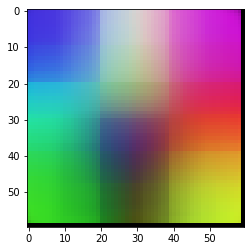

Training has been done !


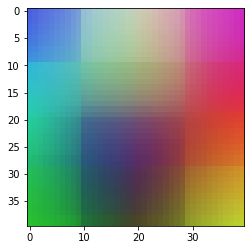

In [7]:
    # set initial variables
    som = Kohonen(dimension=3, width=40, height=40)

    # fitting to the Kohonen map
    som.fit(pixels, random_sampling=0.4, n_iter=20, dist_method=Kohonen.EUCLIDEAN)

    result = (som.node_vectors * 100).astype(int)
    plt.imshow(result)
    plt.show()

Iteration 1/20 Average distance = 0.0057127054267787445
Iteration 2/20 Average distance = 0.0040315489061288675
Iteration 3/20 Average distance = 0.0040856740708151195
Iteration 4/20 Average distance = 0.0038802444054714703
Iteration 5/20 Average distance = 0.00380949437219153
Iteration 6/20 Average distance = 0.0037437794086671505
Iteration 7/20 Average distance = 0.003686136902499147
Iteration 8/20 Average distance = 0.0036125972734509402
Iteration 9/20 Average distance = 0.0035683819020541907
Iteration 10/20 Average distance = 0.0034912843492991286
Iteration 11/20 Average distance = 0.0034442345030474284
Iteration 12/20 Average distance = 0.003402752955056601
Iteration 13/20 Average distance = 0.0033920881863908382
Iteration 14/20 Average distance = 0.003381113322358046
Iteration 15/20 Average distance = 0.0033693507518708643
Iteration 16/20 Average distance = 0.0033597105051707487
Iteration 17/20 Average distance = 0.003351750098806053
Iteration 18/20 Average distance = 0.003346992

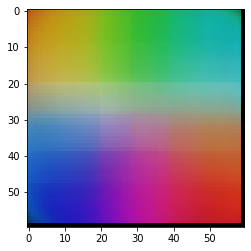

Training has been done !


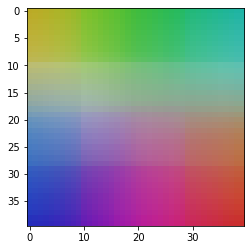

In [8]:
    # set initial variables
    som = Kohonen(dimension=3, width=40, height=40)

    # fitting to the Kohonen map
    som.fit(pixels, random_sampling=0.4, n_iter=20, dist_method=Kohonen.COSINE)

    result = (som.node_vectors * 100).astype(int)
    plt.imshow(result)
    plt.show()

In [9]:
class Kohonen:
    # distance measurement mechanisms
    COSINE = 'cosine'
    EUCLIDEAN = 'euclidean'
    NONE = 'none'

    LEARNING_RATE_DECAY = 0.78
    UPDATE_RANGE_FACTOR = 0.75
    UPDATE_RANGE_DECAY = 0.75

    def __init__(self, width, height, dimension):
        self.x = width
        self.y = height
        self.node_dim = dimension

        # fitting main variables
        self.n_iter = 0  # number of the iterations
        self.batch_size = 0  # number of each batch
        self.input_arr = np.array([])  # input array, given in fit function
        self.dist_method = Kohonen.NONE  # the distance mechanism

        self.node_vectors = np.array([])  # nodes' vectors

        # learning rate
        self.learning_rate = 0

        self.update_range = 0  # the range and distance that would be updated
        self.neighbor_diff = np.array([])

        self.weights = np.array([])  # the neighbor weights
        self.x_delta = []
        self.y_delta = []

    def init_map(self):
        """
        generates random numbers for node vectors and normalize them with mean of the input array.
        :return:
        """
        random_array = np.random.rand(self.y, self.x, self.node_dim)
        normal_factor = (np.mean(self.input_arr) / np.mean(random_array))
        self.node_vectors = random_array * normal_factor

    def distance(self, vector_a, vector_b):
        """
        calculate the distance between vector_a and vector_b
        :param vector_a:
        :param vector_b:
        :return:
        """
        if self.dist_method == Kohonen.COSINE:
            # https://en.wikipedia.org/wiki/Cosine_similarity
            dist = 1. - np.dot(vector_a, vector_b) / (np.linalg.norm(vector_a) * np.linalg.norm(vector_b))
        elif self.dist_method == Kohonen.EUCLIDEAN:
            dist = np.linalg.norm(vector_a - vector_b)
        else:
            raise TypeError
        return dist

    def update_node_vectors(self, closest_nodes_idx):
        """
        updating the weights
        :param closest_nodes_idx:
        :return:
        """
        for idx in range(closest_nodes_idx.shape[0]):
            y = closest_nodes_idx[idx, 0]
            x = closest_nodes_idx[idx, 1]
            inp_idx = closest_nodes_idx[idx, 2]
            input_vector = self.input_arr[inp_idx]

            x_range = x + self.x_delta + self.update_range
            y_range = y + self.y_delta + self.update_range

            previous = self.node_vectors[y_range, x_range]

            update_vector = self.weights * self.learning_rate * (np.expand_dims(input_vector, axis=0) - previous)

            self.node_vectors[y_range, x_range, :] += update_vector

    def find_best_matching_node(self, data_vector):
        """
        this method is for finding best & closest vector.
        :param data_vector:
        :return: (x, y, distance) coordinates and distance
        """
        min_dist = None
        x = None
        y = None
        for y_idx in range(self.y):
            for x_idx in range(self.x):
                node_vector = self.node_vectors[y_idx + self.update_range, x_idx + self.update_range]
                dist = self.distance(data_vector, node_vector)
                if min_dist is None or min_dist > dist:
                    min_dist = dist
                    x = x_idx
                    y = y_idx

        return y, x, min_dist

    def calculate_neighbor_diff(self):
        """
        find diff for calculating sigma. diff is (x[i,j] - mean) ^ 2
        :return:
        """
        size = self.update_range * 2
        mean = size / 2.0

        diff = []
        y_delta = []
        x_delta = []
        for i in range(size):
            diff.append([])
            for j in range(size):
                diff[i].append([])
                for k in range(self.node_dim):
                    diff[i][j].append((j - mean) ** 2.0 + (i - mean) ** 2.0)
                y_delta.append(i - int(mean))
                x_delta.append(j - int(mean))

        self.neighbor_diff = np.array(diff)
        self.x_delta = np.array(x_delta, dtype=np.int32)
        self.y_delta = np.array(y_delta, dtype=np.int32)

    def calculate_neighbor_effect(self, iteration):
        """
        calculate the effect of update for the neighbors using Gaussian bell equation.
        :param iteration: the equation depends on the iteration index
        :return:
        """

        size = self.update_range * 2

        # standard deviation
        standard_deviation_factor = (size / 2) * Kohonen.UPDATE_RANGE_DECAY ** (iteration * 0.3 + 1)
        standard_deviation = standard_deviation_factor * (np.sum(self.neighbor_diff) ** (1 / 2)) / size ** 2

        # standard calculate the Gaussian bell plot
        e_factor = 1.0 / (math.sqrt(2 * math.pi) * standard_deviation)
        e_exponent_factor = (-1 / 2) * (1 / standard_deviation) ** 2
        weights = e_factor * math.e ** (e_exponent_factor * self.neighbor_diff)

        weights /= np.max(weights)
        weights = weights.reshape(size * size, 3)
        self.weights = weights

    def fit(self, input_arr, n_iter, batch_size=30, learning_rate=0.25, random_sampling=1.0, dist_method=EUCLIDEAN):
        """
        fit method is for training kohonen map.
        :param input_arr:
        :param n_iter:
        :param batch_size:
        :param learning_rate:
        :param random_sampling:
        :param dist_method:
        :return:
        """

        self.input_arr = input_arr
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.dist_method = dist_method
        self.learning_rate = learning_rate
        self.update_range = int(min(self.x, self.y) * Kohonen.UPDATE_RANGE_FACTOR)

        self.init_map()

        # add some fake element to the vectors to ease the process of updating neighbors
        radius = self.update_range
        size = 2 * radius
        tmp_node_vectors = np.zeros((self.y + size, self.x + size, self.node_dim))
        tmp_node_vectors[radius: radius + self.y, radius: radius + self.x] = self.node_vectors.copy()
        self.node_vectors = tmp_node_vectors

        # sampling and batches
        n_samples = int(self.input_arr.shape[0] * random_sampling)
        data_idx_arr = np.arange(self.input_arr.shape[0])
        np.random.shuffle(data_idx_arr)
        batch_count = math.floor(n_samples / self.batch_size)

        self.calculate_neighbor_diff()

        # training
        for iter_idx in range(self.n_iter):

            # calculate update effect on the neighbors
            self.calculate_neighbor_effect(iter_idx)

            # Temporary variables
            total_dist = 0

            for batch in range(batch_count):
                closest_nodes_idx = np.zeros((self.batch_size, 3), dtype=np.int32)

                for item in range(self.batch_size):
                    input_idx = data_idx_arr[batch * self.batch_size + item]
                    input_vector = self.input_arr[input_idx]
                    y, x, dist = self.find_best_matching_node(input_vector)
                    closest_nodes_idx[item, 0] = y
                    closest_nodes_idx[item, 1] = x
                    closest_nodes_idx[item, 2] = input_idx
                    total_dist += dist

                self.update_node_vectors(closest_nodes_idx)

            print('Iteration {}/{} Average distance = {}'.format(iter_idx + 1, self.n_iter, total_dist / n_samples))

            self.learning_rate *= Kohonen.LEARNING_RATE_DECAY

        import matplotlib.pyplot as plt
        plt.imshow((self.node_vectors * 100).astype(int))
        plt.show()

        # Remove padding from the vector map
        self.node_vectors = self.node_vectors[self.update_range: self.update_range + self.y,
                            self.update_range: self.update_range + self.x]

        print("Training has been done !")


Iteration 1/20 Average distance = 0.7001130733080974
Iteration 2/20 Average distance = 0.6918917535952305
Iteration 3/20 Average distance = 0.6646875704015665
Iteration 4/20 Average distance = 0.6325332548963047
Iteration 5/20 Average distance = 0.5988669564904234
Iteration 6/20 Average distance = 0.5604165437966675
Iteration 7/20 Average distance = 0.5246746586719649
Iteration 8/20 Average distance = 0.4925666591047104
Iteration 9/20 Average distance = 0.46459329506997904
Iteration 10/20 Average distance = 0.4398099140634546
Iteration 11/20 Average distance = 0.41804454876723474
Iteration 12/20 Average distance = 0.3998870132681341
Iteration 13/20 Average distance = 0.38483798429960353
Iteration 14/20 Average distance = 0.37181740382616485
Iteration 15/20 Average distance = 0.36093702678099426
Iteration 16/20 Average distance = 0.35208035128990606
Iteration 17/20 Average distance = 0.34490246542451886
Iteration 18/20 Average distance = 0.3391236230716531
Iteration 19/20 Average distan

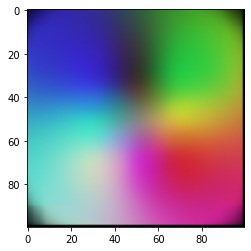

Training has been done !


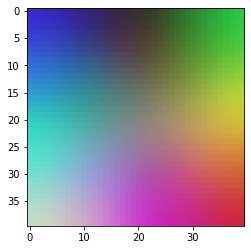

In [10]:
    # set initial variables
    som = Kohonen(dimension=3, width=40, height=40)

    # fitting to the Kohonen map
    som.fit(pixels, random_sampling=0.4, n_iter=20, dist_method=Kohonen.EUCLIDEAN)

    result = (som.node_vectors * 100).astype(int)
    plt.imshow(result)
    plt.show()

Iteration 1/20 Average distance = 0.02643953097853039
Iteration 2/20 Average distance = 0.022553913228291582
Iteration 3/20 Average distance = 0.020525273753026377
Iteration 4/20 Average distance = 0.018348686466439116
Iteration 5/20 Average distance = 0.016245963054530927
Iteration 6/20 Average distance = 0.014211122204282386
Iteration 7/20 Average distance = 0.012336046541724734
Iteration 8/20 Average distance = 0.010649801698899904
Iteration 9/20 Average distance = 0.0091848466260281
Iteration 10/20 Average distance = 0.00793838934744466
Iteration 11/20 Average distance = 0.006899279456558362
Iteration 12/20 Average distance = 0.006030005682125357
Iteration 13/20 Average distance = 0.00532889076075795
Iteration 14/20 Average distance = 0.004765287938737354
Iteration 15/20 Average distance = 0.00431571270368873
Iteration 16/20 Average distance = 0.003962916563399225
Iteration 17/20 Average distance = 0.0036862142062644085
Iteration 18/20 Average distance = 0.0034713038235936544
Itera

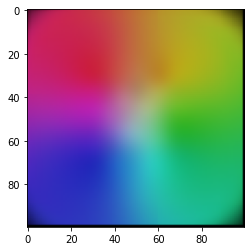

Training has been done !


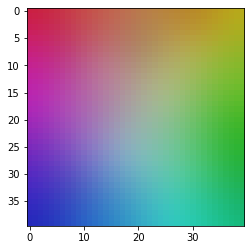

In [11]:
    # set initial variables
    som = Kohonen(dimension=3, width=40, height=40)

    # fitting to the Kohonen map
    som.fit(pixels, random_sampling=0.4, n_iter=20, dist_method=Kohonen.COSINE)

    result = (som.node_vectors * 100).astype(int)
    plt.imshow(result)
    plt.show()

# Q2.A. MLP

In [12]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import Sequential
from keras.layers import Dense
from keras.callbacks import History
import matplotlib.pyplot as plt

In [13]:
RANGE = 5

# generate the data
x_train = (np.random.rand(4000) - 0.5) * 2
x_test = (np.random.rand(500) - 0.5) * 2
x_train, x_test = x_train.reshape(4000, 1), x_test.reshape(500, 1)
y_train, y_test = (np.sin(x_train * RANGE) + 1)/2 , (np.sin(x_test * RANGE) + 1)/2

model = Sequential([
    Dense(units=30, input_shape=(1,), activation="relu"),
    Dense(units=60, activation="sigmoid"),
    Dense(units=1, activation="sigmoid")
])
model.summary()

batch_size = 200
epochs = 3000
# model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.compile(loss='mean_squared_error', optimizer='SGD', metrics=['mean_squared_error', 'accuracy'])
# history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=2)

history = History()
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=2, callbacks=[history])
predictions = model.predict(x_test)
print(np.mean(np.square(predictions - y_test)))

#
# fig, (ax_acc, err_ax) = plt.subplots(1, 2)
#
# err_ax.plot(np.arange(epochs), history.history.get('loss'))
# ax_acc.plot(np.arange(epochs), history.history.get('accuracy'))
#
# fig.show()


Streaming output truncated to the last 5000 lines.
18/18 - 0s - loss: 0.1246 - mean_squared_error: 0.1246 - accuracy: 0.0000e+00 - val_loss: 0.1255 - val_mean_squared_error: 0.1255 - val_accuracy: 0.0000e+00
Epoch 502/3000
18/18 - 0s - loss: 0.1245 - mean_squared_error: 0.1245 - accuracy: 0.0000e+00 - val_loss: 0.1255 - val_mean_squared_error: 0.1255 - val_accuracy: 0.0000e+00
Epoch 503/3000
18/18 - 0s - loss: 0.1245 - mean_squared_error: 0.1245 - accuracy: 0.0000e+00 - val_loss: 0.1254 - val_mean_squared_error: 0.1254 - val_accuracy: 0.0000e+00
Epoch 504/3000
18/18 - 0s - loss: 0.1245 - mean_squared_error: 0.1245 - accuracy: 0.0000e+00 - val_loss: 0.1254 - val_mean_squared_error: 0.1254 - val_accuracy: 0.0000e+00
Epoch 505/3000
18/18 - 0s - loss: 0.1245 - mean_squared_error: 0.1245 - accuracy: 0.0000e+00 - val_loss: 0.1254 - val_mean_squared_error: 0.1254 - val_accuracy: 0.0000e+00
Epoch 506/3000
18/18 - 0s - loss: 0.1245 - mean_squared_error: 0.1245 - accuracy: 0.0000e+00 - val_loss:

Test loss: 0.0034994028974324465


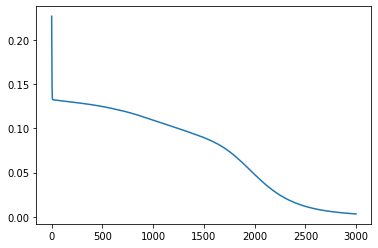

In [14]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])

fig, err_ax = plt.subplots(1, 1)

err_ax.plot(np.arange(epochs), history.history.get('loss'))
fig.show()

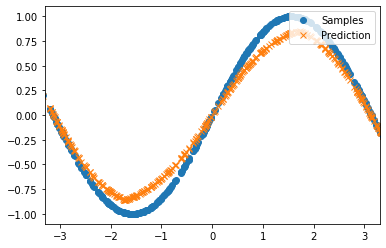

In [15]:
fig, ax = plt.subplots(1, 1) 

plt.plot(x_test * RANGE, y_test * 2 - 1, 'o')
plt.plot(x_test * RANGE, model.predict(x_test) * 2 - 1, 'x')
plt.xlim([-3.3, 3.3])
plt.legend(['Samples', 'Prediction'],loc='upper right')
fig.show()


# Q2.B. RBF

In [16]:
import tensorflow as tf
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import sys

tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [17]:
class RBF:

  RANGE = 5

  def __init__(self, func):
    self.func = func

    self.n_samples = 0  # number of samples

  def add_noise_to_dataset(self, value, input, output):
      x_noise = value[0]
      y_noise = value[1]

      n = self.n_samples
      noise_x = np.random.uniform(-x_noise, x_noise, n).reshape(n, -1) 
      noise_y = np.random.uniform(-y_noise, y_noise, n).reshape(n, -1)

      input += noise_x
      output += noise_y

      return input, output

  def generate_samples(self, n_samples, noise=None):
      self.n_samples = n_samples

      x = np.linspace(-RANGE, RANGE, self.n_samples).reshape(-1,1)
      y = self.func(x)

      if noise is not None:
        x, y = self.add_noise_to_dataset(noise, x, y)

      return x, y

  def define_radial_base(self, x, c, s, hidden_size, feature):
    """
    using Gaussian bell equation to define the radial base.
    :param self: 
    :param x: 
    :param c: 
    :param s: 
    :param hidden_size: 
    :param feature: 
    :return: 
    """
    x1=tf.tile(x,[1,hidden_size]) #Copy x horizontally hidden times
    x2=tf.reshape(x1,[-1,hidden_size,feature])
    dist=tf.reduce_sum((x2-c)**2,2)
    return tf.exp(-dist/(2*s**2))

  def fit(self, x, y, hidden_size, epoch=1500):
      n_feature = x.shape[1] 

      estimator=KMeans(n_clusters=hidden_size, max_iter=10000)
      estimator.fit(x)
      cluster_center = estimator.cluster_centers_
      n = len(cluster_center)
      standard_dev = 0;
      for i in range(n):
          j=i+1
          while j < n:
              t = np.sum((cluster_center[i] - cluster_center[j]) ** 2)
              standard_dev = max(standard_dev, t)
              j = j + 1
      standard_dev =  np.sqrt(standard_dev) / np.sqrt(2*n)


      xx = tf.placeholder(tf.float32, [None, n_feature])
      yy = tf.placeholder(tf.float32, [None, 1])

      z = self.define_radial_base(xx, cluster_center, standard_dev, hidden_size, n_feature)  
  
      self.w =tf.Variable(tf.random_normal([hidden_size,1]))
      self.b = tf.Variable(tf.zeros([1]))
      yf = tf.matmul(z, self.w) + self.b
      
      loss = tf.reduce_mean(tf.square(yy-yf))
      optimizer = tf.train.AdamOptimizer(0.001)
      train = optimizer.minimize(loss)
      init = tf.global_variables_initializer()
  
      session = tf.Session()
      session.run(init)
      for iter_idx in range(epoch + 1):
          session.run(train, feed_dict={xx : x, yy : y})
          if iter_idx > 0 and iter_idx % 250 == 0:
              mse = session.run(loss,feed_dict={xx : x, yy : y})
              sys.stdout.write(f'iteration {iter_idx + 1}/{epoch + 1} \t\t [' + '=' * (iter_idx // 250) + '>' + ' ' * (epoch // 250 - iter_idx // 250) + f'] \t Error {mse}\n')
 
      pre=session.run(yf,feed_dict={xx : x, yy : y})
 
      session.close()

      print("Training has been done !")

      return pre

rbf = RBF(lambda x: np.sin(x))
x, y = rbf.generate_samples(200, (0.15, 0.15))

prediction = rbf.fit(x, y, 4, epoch=15000)


iteration 251/15001 		 [=>                                                           ] 	 Error 0.7706418037414551
iteration 501/15001 		 [==>                                                          ] 	 Error 0.6980670094490051
iteration 751/15001 		 [===>                                                         ] 	 Error 0.6587925553321838
iteration 1001/15001 		 [====>                                                        ] 	 Error 0.6268857717514038
iteration 1251/15001 		 [=====>                                                       ] 	 Error 0.5987396836280823
iteration 1501/15001 		 [======>                                                      ] 	 Error 0.5723700523376465
iteration 1751/15001 		 [=======>                                                     ] 	 Error 0.5464138984680176
iteration 2001/15001 		 [========>                                                    ] 	 Error 0.5203287601470947
iteration 2251/15001 		 [=========>                                                

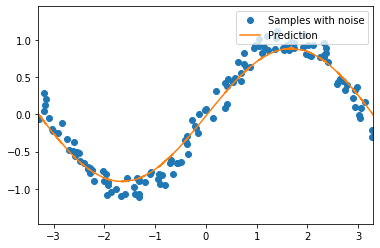

In [18]:
plt.plot(x, y, 'o')
plt.plot(x, prediction)
plt.xlim([-3.3, 3.3])
plt.legend(['Samples with noise', 'Prediction'],loc='upper right')

# Q2.C. Compare

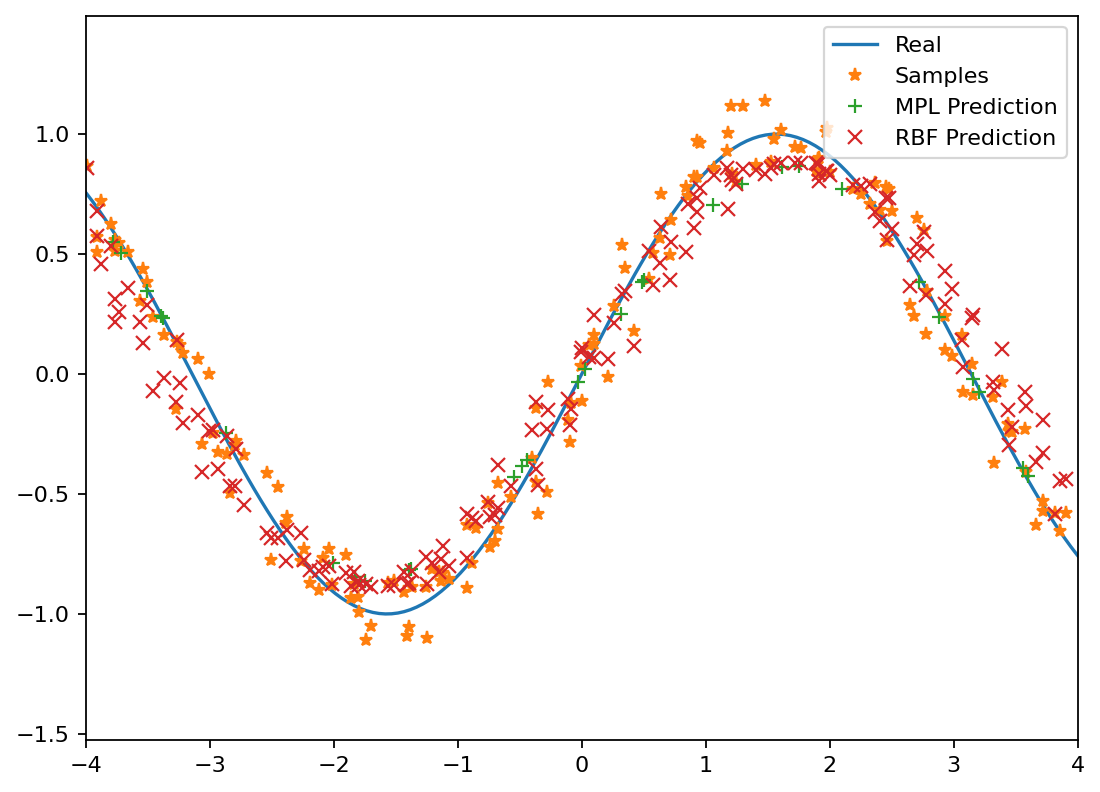

In [276]:
from matplotlib.pyplot import figure 

figure(figsize=(8, 6), dpi=160)

x_exact, y_exact = rbf.generate_samples(200, None)
plt.plot(x_exact, y_exact)
x, y = rbf.add_noise_to_dataset((0.15, 0.15), x_exact, y_exact)
plt.plot(x, y, '*')
plt.plot(x * RANGE, model.predict(x) * 2 - 1, '+')  # MLP
plt.plot(x, prediction, 'x')  # RBF
plt.xlim([-4, 4])
plt.legend(['Real', 'Samples', 'MPL Prediction', 'RBF Prediction'],loc='upper right')

# <font color='red'>Submission</font>

1. Sign up in [Gradescope](https://www.gradescope.com) with proper name and student ID and use the following code to join the class: <font color='red'>**D5372R**</font>
2. Fill in your full name (seperated by single spaces) and student ID in the beginning of this notebook.
3. After you're done with this notebook, you should do the following:
  - Clear all outputs of the notebook.
  ![clear all outputs](https://i.ibb.co/y6FrttB/Screen-Shot-2021-03-21-at-01-51-42.png)
  - Run all of the cells (if you skipped a question just leave the cell unchanged), and make sure all of your outputs are correct.
  ![run all](https://i.ibb.co/cgRcBZ0/Screen-Shot-2021-03-21-at-01-54-58.png)
  - Save your notebook.
  
  - If you're using Colab, download your notebook.
  ![download ipynb](https://i.ibb.co/2KxYM6K/Screen-Shot-2021-03-21-at-02-03-50.png)
  
  - Put the notebook file you just downloaded and `convert.py` in the same folder run the following command:
  ```bash
  python convert.py
  ```
  This will export your code for each question into a `.py` file.
   

  according to the question number.
  - There are 2 assignments in Gradescope: 

    You should upload your **codes** and your **notebook** in `HW2` section and your final report for all of the questions as a **single pdf** file in `HW2 - Report`. Autograder will automatically check for:
    - `CI992_HW2.ipynb`
    - `Q1.A. Kohonen.py`
    - `Q1.B. Koohonen.py`
    - `Q2.A. MLP.py`
    - `Q2.B. RBF.py`
    - `Q2.C. Compare.py`
    - Your name and ID in the beginning of `.ipynb` file.

    It is important that you <font color='red'>**don't**</font> change the names of these files before submission.

4. If you pass the autograder, you're good to go.